In [1]:
import sys
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch.optim as optim
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


%matplotlib inline
batch_size = 32
epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

In [3]:
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print("Using {} dataloader workers every process".format(nw))

Using 4 dataloader workers every process


In [4]:
train_dataset = torchvision.datasets.MNIST('./data/',
                                         train=True,
                                         download=True,
                                         transform=transform)
val_dataset = torchvision.datasets.MNIST('./data/',
                                         train=False,
                                         download=True,
                                         transform=transform)
train_num = len(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           num_workers = nw)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         num_workers = nw)
val_num = len(val_dataset)
print("train_num:'{}'  val_num:'{}'".format(train_num, val_num))

train_num:'60000'  val_num:'10000'


[tensor(3), tensor(7), tensor(5), tensor(4), tensor(2), tensor(2), tensor(8), tensor(3)]


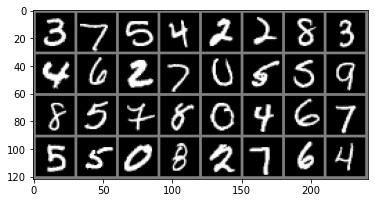

In [5]:
sample, label = next(iter(train_loader))
img = torchvision.utils.make_grid(sample)

img = img.numpy().transpose(1, 2, 0)

img = img * [0.5, 0.5, 0.5] + [0.5, 0.5, 0.5]
print([label[i] for i in range(8)])

plt.imshow(img)
plt.show()

In [6]:
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = BaseNet()

In [7]:
def train_one_epoch(model, optimizer, loss_function, data_loader, device, epoch, epochs):   ##训练模块
    model.train()

    accu_loss = torch.zeros(1).to(device)  # 累计损失
    accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
    optimizer.zero_grad()

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(pred, labels.to(device))
        loss.backward()
        accu_loss += loss.detach()

        data_loader.desc = "train epoch[{}/{}] loss: {:.3f}, acc: {:.3f}".format(epoch + 1,
                                                                                 epochs,
                                                                                 accu_loss.item() / (step + 1),
                                                                                 accu_num.item() / sample_num)

        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)

        optimizer.step()
        optimizer.zero_grad()

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num


@torch.no_grad()
def evaluate(model, loss_function, data_loader, device, epoch, epochs):
    model.eval()

    accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
    accu_loss = torch.zeros(1).to(device)  # 累计损失

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(pred, labels.to(device))
        accu_loss += loss

        data_loader.desc = "valid epoch [{}/{}] loss: {:.3f}, acc: {:.3f}".format(epoch + 1,
                                                                                  epochs,
                                                                                  accu_loss.item() / (step + 1),
                                                                                  accu_num.item() / sample_num)
    return accu_loss.item() / (step + 1), accu_num.item() / sample_num

In [8]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trainLoss = []
trainAcc = []
valLoss = []
valAcc = []
for epoch in range(epochs):
    # train
    train_loss, train_acc = train_one_epoch(model=model,
                                            optimizer=optimizer,
                                            loss_function=loss_function,
                                            data_loader=train_loader,
                                            device=device,
                                            epoch=epoch,
                                            epochs=epochs)
    # validate
    val_loss, val_acc = evaluate(model=model,
                                 loss_function=loss_function,
                                 data_loader=val_loader,
                                 device=device,
                                 epoch=epoch,
                                 epochs=epochs)

    trainLoss.append(train_loss)
    trainAcc.append(train_acc)
    valLoss.append(val_loss)
    valAcc.append(val_acc)

    torch.save(model.state_dict(), "./model-{}.pth".format(epoch))

valid epoch [30/30] loss: 0.063, acc: 0.992: 100%|██████████| 313/313 [00:05<00:00, 54.97it/s] 


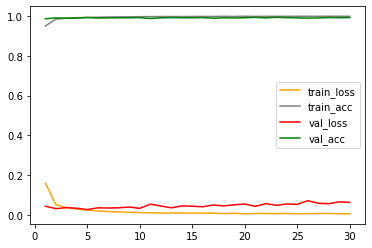

In [22]:
plt.subplot()
x = range(1, len(trainLoss)+1)
plt.plot(x, trainLoss, label='train_loss', color='orange')
plt.plot(x, trainAcc, label='train_acc', color='grey')
plt.plot(x, valLoss, label='val_loss', color='red')
plt.plot(x, valAcc, label='val_acc', color='green')
plt.legend()
plt.show()
